In [114]:
import queue
import pickle 
import winsound
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

- `JID`: integer number representing the identifier of a job
- `TID`: an integer number between 0 and nj, representing the identifier of tasks belonging to job j
- `ta`: arrival time of task measured in milliseconds
- `C`: running time in seconds required to run the task on a Google Normalized Computing Unit (GNCU)
- `M`: amount of memory required to run the task, expressed in Google Normalized Memory Unit (GNMU)
- `N`: number of servers
- `X = C/µ`: service time of a task
- `1 GNMU`: amount of memory of a server
- `µ`: processing power expressed in `GNCU`

In [115]:
# Import data.
data = pd.read_csv('Cell_a.csv')

# Check if we import all the rows.
if data.shape[0] == 2329133:
    print('All rows correctly imported! \U0001f44d')

# Rename columns.
data = data.rename(columns={'Job_ID': 'JID',
                            'Task_ID': 'TID',
                            'Arrival_Time': 't_a',
                            'CPU': 'C',
                            'Memory': 'M'})
data.t_a = data.t_a / 1e6
data = data.sort_values('t_a', ignore_index=True)
data['n_tasks'] = data.groupby('JID')['JID'].transform('count')


data.head()

All rows correctly imported! 👍


,JID,TID,t_a,C,M,n_tasks
0,375000667413,0,603.026300,0.041851,0.001169,1
1,375000669289,0,606.413041,0.024968,0.001179,1
2,375000670586,0,608.994453,0.024176,0.001173,1
3,375000670588,0,608.994466,0.019552,0.001163,1
4,375000670590,0,609.042903,0.028044,0.001179,1


### Data exploration and visualization

In [ ]:
pd.DataFrame(data.groupby('JID').count().TID)

,TID
JID,
375000667413,1
375000669289,1
375000670586,1
375000670588,1
375000670590,1
...,...
400465207745,1
400465219425,2
400465256347,1


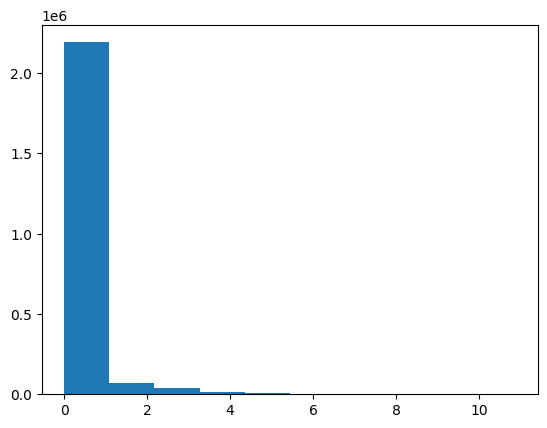

In [ ]:
plt.hist(np.log(data.C+1));

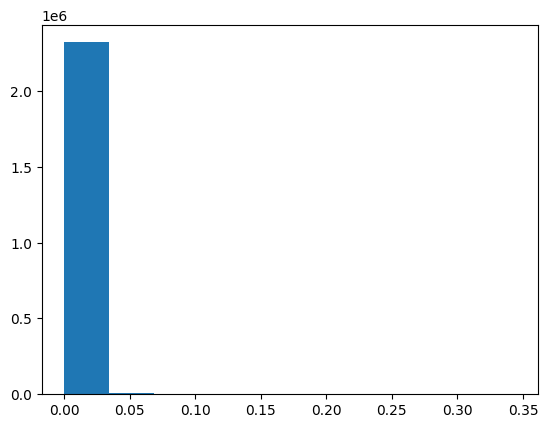

In [ ]:
plt.hist(np.log(data.M+1));

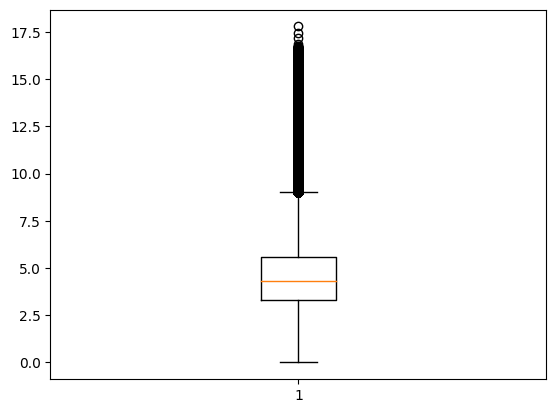

In [ ]:
plt.boxplot(np.log(data.C+1));

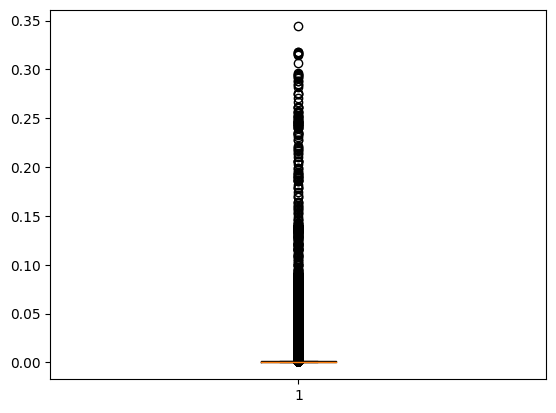

In [ ]:
plt.boxplot(np.log(data.M+1));

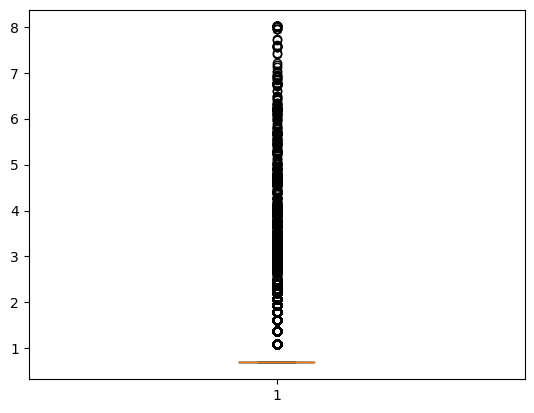

In [ ]:
freq = pd.DataFrame(data.groupby('JID').count().TID)
plt.boxplot(np.log(freq+1));

In [ ]:
print(data.M.describe())
print(data.C.describe())

count    2.329133e+06
mean     1.497997e-03
std      5.076826e-03
min      0.000000e+00
25%      5.397797e-04
50%      8.687973e-04
75%      1.123428e-03
max      4.106445e-01
Name: M, dtype: float64
count    2.329133e+06
mean     3.962583e+03
std      1.357256e+05
min      0.000000e+00
25%      2.649117e+01
50%      7.241821e+01
75%      2.701645e+02
max      5.278707e+07
Name: C, dtype: float64


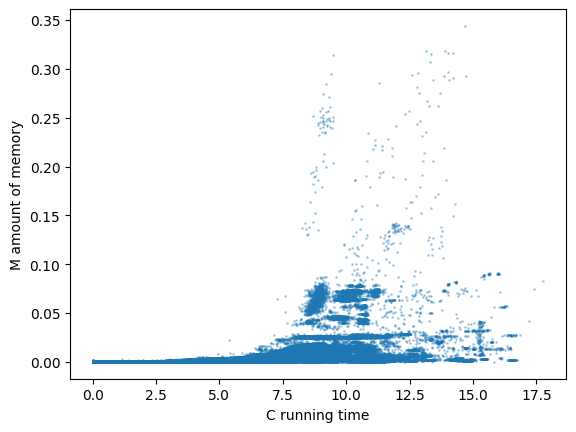

In [ ]:
plt.scatter(np.log(data.C+1), np.log(data.M+1), s=1, alpha=0.3)
plt.xlabel('C running time')
plt.ylabel('M amount of memory');

In [ ]:
plt.scatter(data.t_a, np.log(data.C+1), c=data.JID, s=1, alpha=0.3)
plt.xlabel('Arrival time')
plt.ylabel('C running time');

: 

: 

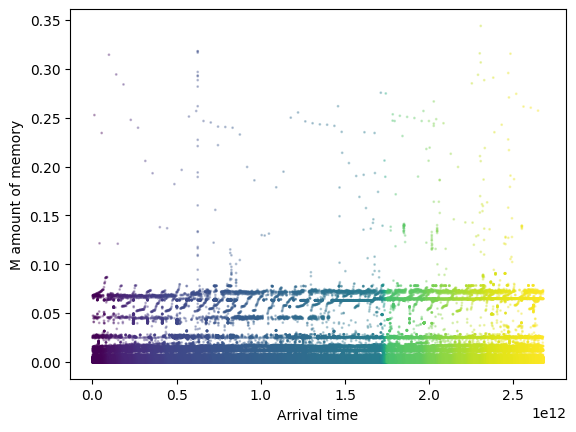

In [ ]:
plt.scatter(data.t_a, np.log(data.M+1), c=data.JID, s=1, alpha=0.3)
plt.xlabel('Arrival time')
plt.ylabel('M amount of memory');

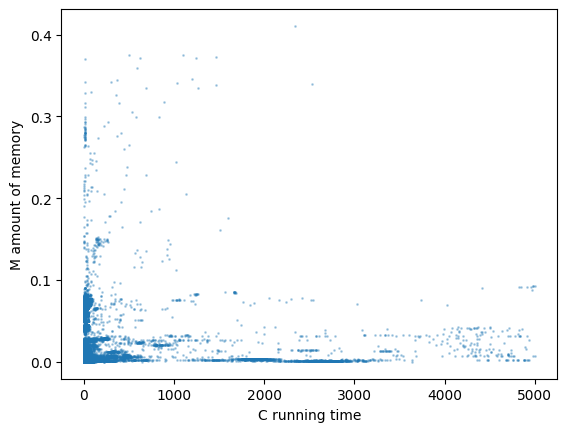

In [ ]:
plt.scatter(data.loc[data.C<5000].C, data.loc[data.C<5000].M, s=1, alpha=0.3)
plt.xlabel('C running time')
plt.ylabel('M amount of memory');

### Set parameters

In [116]:
N = 64
mu = 0.1

The purpose of the challenge is to define a dispatching
algorithm and scheduling algorithms, one for each server, so
as to get the best possible mean job response time.

### **Baseline algorithms**

- Dispatching: `LWL` 
- Scheduling: `FCFS` 

In [117]:
class Task:

    def __init__(self, job_id, task_id, ta, X, n_tasks):
        global mu

        self.jid = job_id
        self.tid = task_id
        self.ta = ta
        self.X = X
        self.end_time = self.X
        self.n_tasks = n_tasks


    # To avoid comaprison problems among different Tasks.
    def __lt__(self, other):
        return self.ta < other.ta

In [118]:
class ServerBL:

    def __init__(self, server_id):
        self.server_id = server_id
        self.workload = 0
        self.time = 0
        self.utilization = 0
        self.n_messages = 0


    def compute_workload(self, task):
        delta_time = task.ta - self.time
        self.n_messages += 2


        # Check remainig workload after delta t.
        self.workload = max(self.workload - delta_time, 0)
        self.time = task.ta
        

    def assign_task(self, task):

        # Computing end time for the new task.
        task.end_time += self.workload
        
        # Add new task time to workload.
        self.workload += task.X
        self.utilization += task.X
        self.n_messages += 1

In [119]:
# How to decide to which servers assign the new task.
def LWL(task, servers):
    
    min_workload = float('inf')
    selected_server = None

    for server in servers:
        server.compute_workload(task)
        if server.workload < min_workload:
            min_workload = server.workload
            selected_server = server

    selected_server.assign_task(task)

In [120]:
# Simulation function.
def simulation_baseline(data, N):
    print('-' * 14)
    print('-- BASELINE --')
    print('-' * 14)


    global servers
    global tasks

    # Creating servers objects.
    servers = [ServerBL(i) for i in range(N)]

    # Creating tasks object.
    print('\n\u231B Creating task objects...')
    tasks = []
    for _, row in tqdm(data.iterrows()):
        jid, tid, ta, C, M, n_tasks = row.values
        tasks.append(Task(int(jid), int(tid), float(ta), float(C/mu), int(n_tasks)))
    print('\u2714\uFE0F Objects created!')

    # Execute dispatcher for each task.
    print("\n\u231B Running the 'simulation'...")
    for task in tqdm(tasks):
        LWL(task, servers) 
    print("\u2714\uFE0F 'Simulation' completed!")

"Simulation"

In [121]:
# data = data.head(1_000)

simulation_baseline(data, N)

--------------
-- BASELINE --
--------------

⌛ Creating task objects...


2329133it [01:06, 35285.47it/s]


✔️ Objects created!

⌛ Running the 'simulation'...


100%|██████████| 2329133/2329133 [01:01<00:00, 37817.21it/s]

✔️ 'Simulation' completed!


#### Results

In [122]:
# Tasks baseline.
rows = []
for task in tasks:
    new_row = vars(task)
    row = {key: val for key, val in new_row.items()}
    rows.append(row)
df_tasks_bl = pd.DataFrame(rows)
df_tasks_bl['final_time'] = df_tasks_bl['ta'] + df_tasks_bl['end_time']

# Stats baseline.
stats_df_bl = df_tasks_bl.groupby('jid').agg({'ta': 'min', 'final_time': 'max', 'X': 'sum'})
stats_df_bl = stats_df_bl.rename(columns={'ta': 'min_ta', 'final_time': 'max_ta_end_time', 'X': 'tot_job_X'})
stats_df_bl['R'] = stats_df_bl['max_ta_end_time'] - stats_df_bl['min_ta']
stats_df_bl = stats_df_bl.reset_index()
stats_df_bl = stats_df_bl.drop(stats_df_bl[stats_df_bl.tot_job_X == 0].index)
stats_df_bl['S'] = stats_df_bl['R'] / stats_df_bl['tot_job_X']
stats_df_bl['S'] = stats_df_bl['S'].replace(np.inf, 1)
stats_df_bl['S'] = stats_df_bl['S'].replace(np.nan, 1)

# Servers baseline.
rows = []
for server in servers:
    new_row = vars(server)
    row = {key: val for key, val in new_row.items()}
    rows.append(row)
df_servers_bl = pd.DataFrame(rows)

# Summaries
R_avg_bl = stats_df_bl.R.mean()
S_avg_bl = stats_df_bl.S.mean()
tot_task_arrival_bl = max(df_tasks_bl['final_time']) - min(data.t_a)
rho_bl = df_servers_bl.utilization / tot_task_arrival_bl
rho_avg_bl = rho_bl.mean()
l_avg_bl = df_servers_bl.n_messages.mean()

summaries = {'Metric': ['Job responde time (R)', 'Job slowdown (S)', 'Utilization coefficient (rho)', 'Messaging load (L)'],
             'Baseline': [round(R_avg_bl, 2), round(S_avg_bl, 2), round(rho_avg_bl, 3), round(l_avg_bl, 2)]}

df_summaries = pd.DataFrame(summaries)
df_summaries

,Metric,Baseline
0,Job responde time (R),27601.160
1,Job slowdown (S),1241639.330
2,Utilization coefficient (rho),0.538
3,Messaging load (L),4694658.700


### **Our algorithms**

- Dispatching: `based on number of tasks per job and splitting the servers for different dimensionality using the one of the chosen category with least workload` 
- Scheduling: `SJF` 

In [22]:
class ServerOUR:
    
    def __init__(self, server_id):
        self.server_id = server_id
        self.workload = 0
        self.time = 0
        self.utilization = 0
        self.n_messages = 0
        self.queue = queue.PriorityQueue()
        self.running_task = []


    def compute_workload(self, task):
        delta_time = task.ta - self.time
        self.n_messages += 2

        # Try to conclude running task.
        if len(self.running_task) != 0:
            if self.running_task[0].X <= delta_time:
                self.workload -= self.running_task[0].X
                delta_time -= self.running_task[0].X
                self.running_task.pop()
            else:
                self.running_task[0].X -= delta_time
                self.time = task.ta
                self.workload -= delta_time
                return 

        # Take next tasks from the queue.
        for _ in range(self.queue.qsize()):
            self.running_task.append(self.queue.get()[1])
            if self.running_task[0].X <= delta_time:
                self.workload -= self.running_task[0].X
                delta_time -= self.running_task[0].X
                self.running_task.pop()
            else:
                self.running_task[0].X -= delta_time
                self.time = task.ta
                self.workload -= delta_time
                break
        self.time = task.ta

        
        
    def assign_task(self, task):

        # Update time of tasks behind and next this new task.
        if not self.queue.empty():
            for el in self.queue.queue:
                if el[1].X <= task.X:
                    task.end_time += el[1].X
                else:
                    el[1].end_time += task.X
            
        if len(self.running_task) != 0:
            task.end_time += self.running_task[0].X

        # Add task to queue.
        self.queue.put((task.X, task))

        # Add new task time to workload.
        self.workload += task.X
        self.utilization += task.X
        self.n_messages += 1

In [23]:
def our_dispatcher(task, servers, treshold, max_tasks):
    for server in servers:
        server.compute_workload(task)

    if task.n_tasks < max_tasks + 1:
        idx_server = min(range(treshold), key=lambda i: servers[i].workload)
        selected_server = servers[idx_server]
    else:
        idx_server = min(range(treshold, 64), key=lambda i: servers[i].workload)
        selected_server = servers[idx_server]

    selected_server.assign_task(task)

In [24]:
def our_simulation(data, N, treshold, max_tasks):
    print('-' * 14)
    print('-- OUR ALGO --')
    print('-' * 14)

    global servers
    global tasks

    # Creating servers objects.
    servers = [ServerOUR(i) for i in range(N)]

    # Creating tasks object.
    print('\n\u231B Creating task objects...')
    tasks = []
    for _, row in tqdm(data.iterrows()):
        jid, tid, ta, C, M, n_tasks = row.values
        tasks.append(Task(int(jid), int(tid), float(ta), float(C / mu), int(n_tasks)))
    print('\u2714\uFE0F Objects created!')

    # Execute dispatcher for each task.
    print("\n\u231B Running the 'simulation'...")
    for task in tqdm(tasks):
        our_dispatcher(task, servers, treshold, max_tasks) 
    print("\u2714\uFE0F 'Simulation' completed!")
    winsound.Beep(440, 1000)

In [25]:
def evaluate_parameter(treshold, max_tasks):
    treshold = treshold
    our_simulation(data, N, treshold, max_tasks)
    rows = []
    for task in tasks:
        new_row = vars(task)
        row = {key: val for key, val in new_row.items()}
        rows.append(row)
    df_tasks = pd.DataFrame(rows)
    df_tasks['final_time'] = df_tasks['ta'] + df_tasks['end_time']

    # Stats our algo.
    stats_df = df_tasks.groupby('jid').agg({'ta': 'min', 'final_time': 'max', 'X': 'sum'})
    stats_df = stats_df.rename(columns={'ta': 'min_ta', 'final_time': 'max_ta_end_time', 'X': 'tot_job_X'})
    stats_df['R'] = stats_df['max_ta_end_time'] - stats_df['min_ta']
    return stats_df['R'].mean()
    

def find_best_N(LB, UB, results, max_tasks, mid=None, mid_value=None):
    print()
    print('#'*34)
    print(f'### Currently in the interval: ###')
    print(f'### LB={LB}                      ###')
    print(f'### UB={UB}                      ###')
    print('#'*34)
    print()
    if UB - LB > 4:
        mid = (LB + UB) // 2
        if mid in list(results.keys()):
            mid_value = results[mid]
        else:
            mid_value = evaluate_parameter(mid, max_tasks)
        results[mid] = mid_value
        q1 = (mid + LB) // 2
        if q1 in list(results.keys()):
            q1_value = results[q1]
        else:
            q1_value = evaluate_parameter(q1, max_tasks)
        results[q1] = q1_value
        q2 = (mid + UB) // 2
        if q2 in list(results.keys()):
            q2_value = results[q2]
        else:
            q2_value = evaluate_parameter(q2, max_tasks)
        results[q2] = q2_value
        if q2_value < q1_value and q2_value < mid_value:
            LB = mid
            UB = UB
            find_best_N(LB, UB, results, max_tasks, mid, mid_value)
        elif q1_value < q2_value and q1_value < mid_value:
            LB = LB
            UB = mid
            find_best_N(LB, UB, results, max_tasks, mid, mid_value)
        else: 
            LB = q1
            UB = q2
            find_best_N(LB, UB, results, max_tasks, mid, mid_value)
    elif UB - LB == 4:
        mid = (UB + LB) // 2
        if mid not in list(results.keys()):
            results[mid] = evaluate_parameter(mid, max_tasks)
        if mid-1 not in list(results.keys()):
            results[mid-1] = evaluate_parameter(mid-1, max_tasks)
        if mid+1 not in list(results.keys()):
            results[mid+1] = evaluate_parameter(mid+1, max_tasks)

In [ ]:
# max_tasks = 5

# results = dict()
# find_best_N(0, 64, results, max_tasks)
# print('\n\nBest combination to use:')
# results_sorted = dict(sorted(results.items(), key=lambda x: x[1]))
# for key, value in results_sorted.items():
#     print(f'- ({key}, {64-key}) --> E[R]={round(value, 3)}')   


# # Caricamento del dizionario utilizzando pickle
# with open(f'results_{max_tasks}.pkl', 'wb') as file:
#     pickle.dump(results, file)

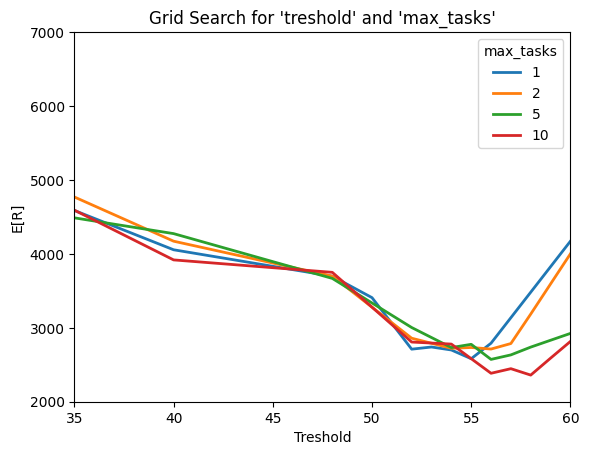

In [138]:
for el in [1, 2, 5, 10]:
    with open(f"pickles\\results_{el}.pkl", 'rb') as file:
        results = pickle.load(file)

    results = dict(sorted(results.items()))
    ticks = results.keys()
    values = results.values()
    plt.plot(ticks, values, label = f'{el}', linewidth=2)

plt.title("Grid Search for 'treshold' and 'max_tasks'")
plt.xlabel('Treshold')
plt.ylabel('E[R]')
plt.xlim(35, 60)
plt.ylim(2_000, 7_000)
plt.legend(title = 'max_tasks');

Set best combination and run final simulation

In [140]:
treshold = 58
max_tasks = 10

In [141]:
our_simulation(data, N, treshold, max_tasks)

--------------
-- OUR ALGO --
--------------

⌛ Creating task objects...


2329133it [01:01, 37734.48it/s]


✔️ Objects created!

⌛ Running the 'simulation'...


100%|██████████| 2329133/2329133 [04:09<00:00, 9349.10it/s] 


✔️ 'Simulation' completed!


In [142]:
# Tasks our algo.
rows = []
for task in tasks:
    new_row = vars(task)
    row = {key: val for key, val in new_row.items()}
    rows.append(row)
df_tasks = pd.DataFrame(rows)
df_tasks['final_time'] = df_tasks['ta'] + df_tasks['end_time']

# Stats our algo.
stats_df = df_tasks.groupby('jid').agg({'ta': 'min', 'final_time': 'max', 'X': 'sum'})
stats_df = stats_df.rename(columns={'ta': 'min_ta', 'final_time': 'max_ta_end_time', 'X': 'tot_job_X'})
stats_df['R'] = stats_df['max_ta_end_time'] - stats_df['min_ta']
stats_df = stats_df.reset_index()
stats_df = stats_df.drop(stats_df[stats_df.tot_job_X == 0].index)
stats_df['S'] = stats_df['R'] / stats_df['tot_job_X']
stats_df['S'] = stats_df['S'].replace(np.inf, 1)
stats_df['S'] = stats_df['S'].replace(np.nan, 1)

# Servers our algo.
rows = []
for server in servers:
    new_row = vars(server)
    row = {key: val for key, val in new_row.items()}
    rows.append(row)
df_servers = pd.DataFrame(rows)
df_servers =df_servers.drop(columns=['queue', 'running_task'])

# Summaries our algo.
R_avg = stats_df.R.mean()
S_avg = stats_df.S.mean()
tot_task_arrival = max(df_tasks['final_time']) - min(data.t_a)
rho = df_servers.utilization / tot_task_arrival
rho_avg = rho.mean()
l_avg = df_servers.n_messages.mean()

df_summaries['Our'] = [round(R_avg, 2), round(S_avg, 2), round(rho_avg, 3), round(l_avg, 2)]

In [143]:
print('-' * 18)
print('--Average values--')
print('-' * 18)
display(df_summaries)

------------------
--Average values--
------------------


,Metric,Baseline,Our
0,Job responde time (R),27601.160,2348.830
1,Job slowdown (S),1241639.330,207371.670
2,Utilization coefficient (rho),0.538,0.183
3,Messaging load (L),4694658.700,4694658.700


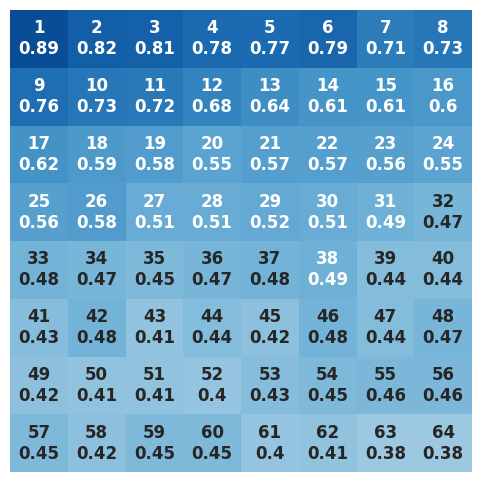

In [261]:
color = ['Blues', 'Blues']
text_size = 8

server_utilizations = {server.server_id+1: round(rho_bl[server.server_id], 2) for server in servers}
matrix = [f"{k}\n{v}" for k, v in server_utilizations.items()]
# matrix = list(server_utilizations.values())


                
category_map = {el:float(el[-3:]) for i, el in enumerate(matrix)}
matrix = np.reshape(matrix, (8,8))


fig, ax = plt.subplots(figsize=(6,6))

text_size = 12
a = np.vectorize(category_map.get)(matrix)


sns.heatmap(ax = ax, data = a, annot = matrix, cmap = color[0], yticklabels=False, xticklabels=False, fmt="", cbar=False, annot_kws={"fontsize": text_size, "weight": 'bold'}, square=True, vmin=0, vmax=1,)

# plt.title('Servers utilization baseline')
plt.show()

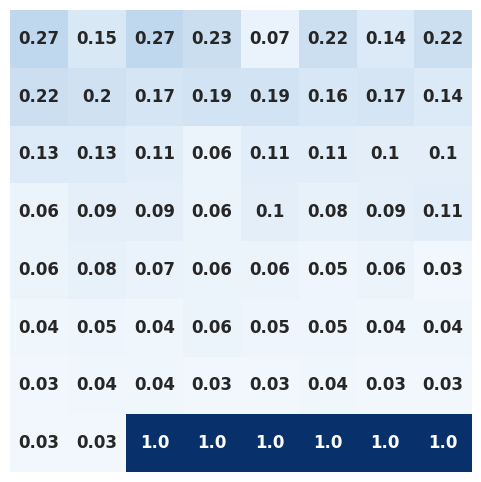

In [260]:
server_utilizations = {server.server_id: round(rho[server.server_id], 2) for server in servers}

matrix = [f"{k}\n{v}" for k, v in server_utilizations.items()]
category_map = {el:float(el[-3:]) for i, el in enumerate(matrix)}

matrix = list(server_utilizations.values())
matrix = np.reshape(matrix, (8, 8))

row = treshold // 8
col = treshold % 8

m1, m2, m3, m4 = matrix.copy(), matrix.copy(), matrix.copy(), matrix.copy()
m1[row:, :] = float('nan')
m2[:row, :] = float('nan')
m2[row+1:, :] = float('nan')
m2[row, col:] = float('nan')

m3[:row, :] = float('nan')
m3[row+1:, :] = float('nan')
m3[row, :col] = float('nan')

m4[:1+row, :] = float('nan')

fig, ax = plt.subplots(figsize=(6,6))
a = np.vectorize(category_map.get)(matrix)

text_size = 12

sns.heatmap(ax = ax, data = m1, annot = True, cmap = color[0], yticklabels=False, xticklabels=False, fmt="", cbar=False, annot_kws={"fontsize": text_size, "weight": 'bold'}, square=True, vmin=0, vmax=1)
sns.heatmap(ax = ax, data = m2, annot = True, cmap = color[0], yticklabels=False, xticklabels=False, fmt="", cbar=False, annot_kws={"fontsize": text_size, "weight": 'bold'}, square=True, vmin=0, vmax=1)
sns.heatmap(ax = ax, data = m3, annot = True, cmap = color[1], yticklabels=False, xticklabels=False, fmt="", cbar=False, annot_kws={"fontsize": text_size, "weight": 'bold'}, square=True, vmin=0, vmax=1)
sns.heatmap(ax = ax, data = m4, annot = True, cmap = color[1], yticklabels=False, xticklabels=False, fmt="", cbar=False, annot_kws={"fontsize": text_size, "weight": 'bold'}, square=True, vmin=0, vmax=1)


# plt.title('Servers utilization our algorithm')
plt.show()

C:\Users\mcm23\AppData\Local\Temp\ipykernel_14612\4130245699.py:10: RuntimeWarning: invalid value encountered in log10
  ax[i].plot(np.log10(ecdf.x), 1- ecdf.y, label='baseline')
C:\Users\mcm23\AppData\Local\Temp\ipykernel_14612\4130245699.py:14: RuntimeWarning: invalid value encountered in log10
  ax[i].plot(np.log10(ecdf.x), 1- ecdf.y, label='our algorithm')


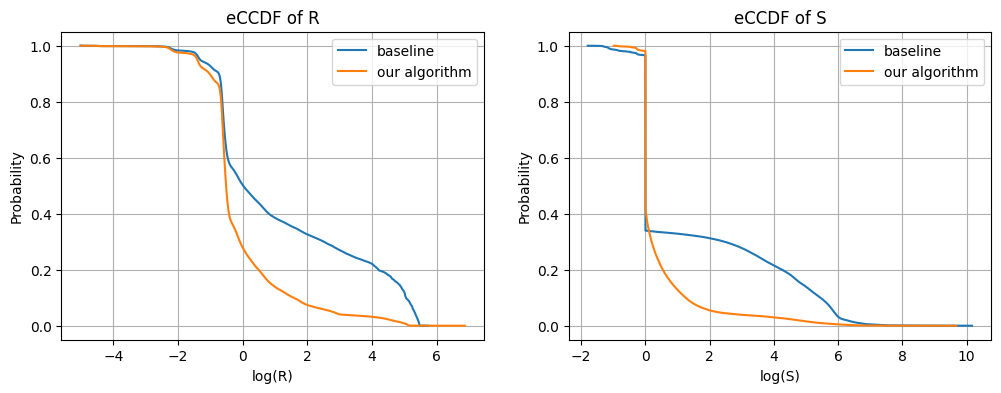

In [215]:
from statsmodels.distributions.empirical_distribution import ECDF

cols = ['green', 'darkorange']
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

titles = ['eCCDF of R', 'eCCDF of S']

for i, vals in enumerate([stats_df_bl.R, stats_df_bl.S]):
    ecdf = ECDF(vals)              
    ax[i].plot(np.log10(ecdf.x), 1- ecdf.y, label='baseline')

for i, vals in enumerate([stats_df.R, stats_df.S]):
    ecdf = ECDF(vals)              
    ax[i].plot(np.log10(ecdf.x), 1- ecdf.y, label='our algorithm')
    ax[i].set_title(titles[i])
    ax[i].legend()

ax[0].set_xlabel('log(R)')
ax[1].set_xlabel('log(S)')
ax[0].set_ylabel('Probability')
ax[1].set_ylabel('Probability')
ax[0].grid()
ax[1].grid()

plt.show()

#### Plottini

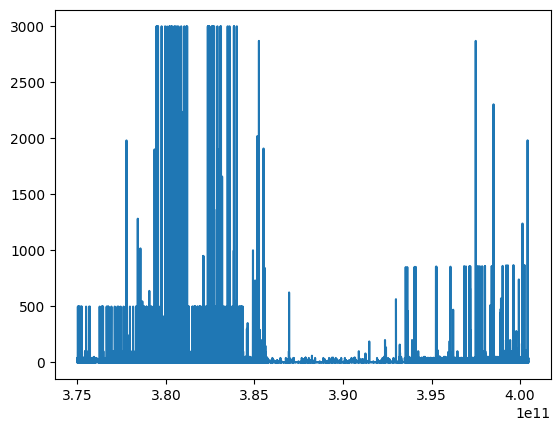

In [ ]:
plt.plot(df_tasks_bl.groupby('jid').count().M)
plt.xticks();

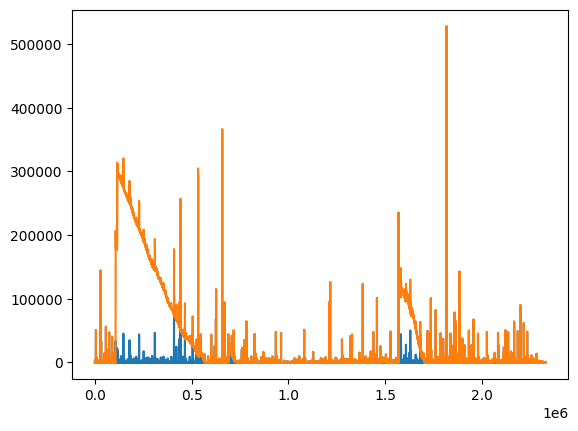

In [ ]:
plt.plot(df_tasks_bl.X)
plt.plot(df_tasks_bl.end_time);

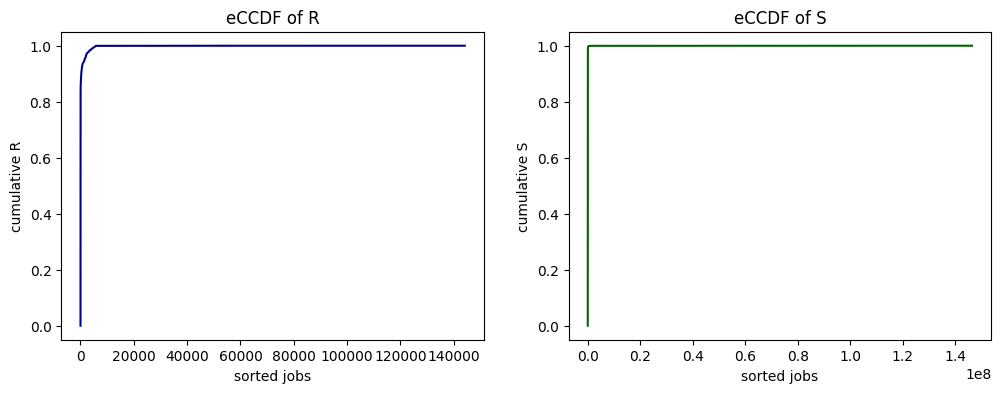

In [ ]:
cols = ['darkblue', 'darkgreen']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sorted_data = np.sort(stats_df_bl.R)
ccdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax[0].plot(sorted_data, ccdf, color = cols[0])
ax[0].set_title('eCCDF of R')
ax[0].set_ylabel('cumulative R')
ax[0].set_xlabel('sorted jobs')

sorted_data = np.sort(stats_df_bl.S)
ccdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax[1].plot(sorted_data, ccdf, color = cols[1])
ax[1].set_title('eCCDF of S')
ax[1].set_ylabel('cumulative S')
ax[1].set_xlabel('sorted jobs')

plt.show()

Values of $\bar{R}$, $\bar{S}$, $\rho$, $\bar{L}$

Where:

- $R$ (job response time) $\longrightarrow$ time elapsing since the arrival of the first arriving task of a job until all tasks belonging to that job have been fully served

- $S$ (job slowdown) $\longrightarrow$ ratio of response time of the job to the sum of service times of all tasks belonging to the job

- $\rho_k$ (utilization coefficient of server $k$) $\longrightarrow$ fraction of time that the server k is busy serving tasks

- $L$ (messaging load) $\longrightarrow$ number of messages exchanged between the dispatcher and servers for a given task dispatching

Table with values of $\rho_k$, with $k=1, ..., 64$

Plot of the empirical Complementary Cumulative Distribution Function (eCCDF) of $R$ and $S$.

Repeating the above performance evaluation for: 

- our algorithms

- baseline algorithms (for comparison purposes), namely, **LWL dispatching** and **FCFS scheduling** in all servers.